In [34]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from qiskit.circuit.library import QFT
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction

### 1. Инициализиране на кюбитите

In [35]:
"""Прилагане на трансформация на Хадамард към измервателен регистър и NOT-гейт"""
def initialize(circuit, n, m):
    circuit.h(range(n)) # Трансформация на Хадамард върху регистър за изчисления
    circuit.x(n+m-1) # Х-гейт на последния кюбит

### 2.  Карта на модулно експонентиране върху измервателни кюбити

Единната операция по-долу представлява
$$U = a^x \text{ mod } 15$$

In [36]:
from qiskit import QuantumCircuit

""" Mодулна операция с контролирано експонентиране за кодиране на периодичната функция в изчислителния регистър"""
def a_x_mod15(a, x):
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    unitary = QuantumCircuit(4)        
    for iteration in range(x):
        # битова аритметика за представяне на функцията за модулно експоненциране
        if a in [2,13]:
            unitary.swap(0,1)
            unitary.swap(1,2)
            unitary.swap(2,3)
        if a in [7,8]:
            unitary.swap(2,3)
            unitary.swap(1,2)
            unitary.swap(0,1)
        if a == 11:
            unitary.swap(1,3)
            unitary.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                unitary.x(q)
    unitary = unitary.to_gate()
    unitary.name = "%i^%i mod 15" % (a, x)

    c_unitary = unitary.control()
    return c_unitary

In [37]:
def qpe_amod15(a):
    n = 4
    qc = QuantumCircuit(4+n, n)
    for q in range(n):
        qc.h(q)     # Инициализиране на q-бити които записват в състояние|+>
    qc.x(3+n) # И спомагателен регистър в състояние |1>
    for q in range(n): # Изпълнява контролирани-U операции
        qc.append(a_x_mod15(a, 2**q), 
                 [q] + [i+n for i in range(4)])
    qc.append(qft_dagger(n), range(n)) # Обратна функция на QFT
    qc.measure(range(n), range(n))
    # Симулация на резултат
    aer_sim = Aer.get_backend('aer_simulator')
    t_qc = transpile(qc, aer_sim)
    qobj = assemble(t_qc, shots=1)
    result = aer_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    print("Четене от регистър: " + readings[0])
    phase = int(readings[0],2)/(2**n)
    print("Съответстваща фаза: %f" % phase)
    return phase

In [38]:
"""Добавяне на подпрограма за модулно експонентиране към дадена схема и по-нататъшно усъвършенстване на входните данни за функцията mod exp"""
def modular_exponentiation(circuit, n, m, a):
    for exp in range(n):
        exponent = 2**exp
        circuit.append(a_x_mod15(a, exponent), [exp] + list(range(n, n+m)))

### 3. Импортираме и схемата за QFT (квантова трансформация на Фурие) и конструираме алгоритъм на Шор.

In [39]:
def qft_dagger(n):
    """n-q-бит QFTdagger първият n q-бит във веригата"""
    qc = QuantumCircuit(n)
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

In [40]:
"""Разкрива периода на модулната експоненциална функция"""
def apply_iqft(circuit, measurement_qubits):
    circuit.append(QFT( len(measurement_qubits), do_swaps=False).inverse(), measurement_qubits)

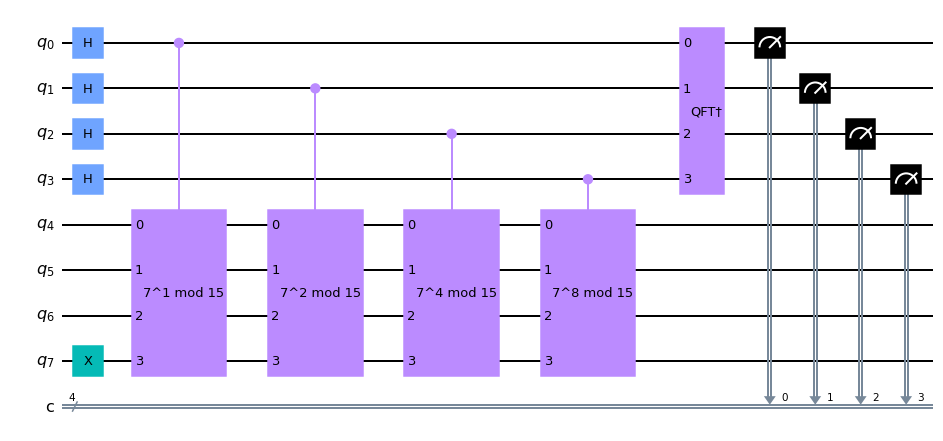

In [41]:
"""Събираме всичко заедно"""
n = 4; m = 4; a = 7
    # Създава QuantumCircuit с n-борй  броящи
   # Плюс 4 q-бити за U за да действа по тях
qc = QuantumCircuit(n + 4, n)



for q in range(n):
    qc.h(q)
    
# Спомагателни регистри в състояние |1>
qc.x(3+n)

# Do controlled-U operations
for q in range(n):
    qc.append(a_x_mod15(a, 2**q), 
             [q] + [i+n for i in range(4)])

# Извършва обратно-QFT
qc.append(qft_dagger(n), range(n))

# Измерва веригата
qc.measure(range(n), range(n))
qc.draw('mpl') 
    
 # връща qc


### Изпълнение на схемата на симулатор

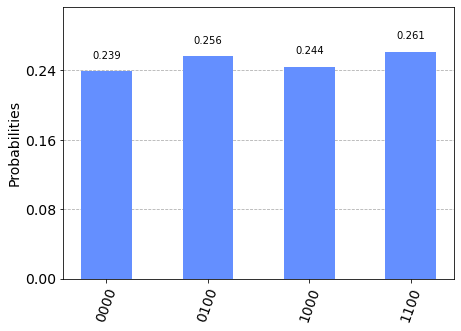

In [42]:
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [43]:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Конвертира (база 2) string към decimal
    phase = decimal/(2**4)  # Намира съответната собствена стойност
    measured_phases.append(phase)
    # Добавете тези стойности към редовете в нашата таблица:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**4} = {phase:.2f}"])
# Отпечатва редовете в таблица
headers=["Изход на регистър", "Фаза"]
df = pd.DataFrame(rows, columns=headers)
print(df)

      Изход на регистър          Фаза
0  0100(bin) =   4(dec)   4/16 = 0.25
1  0000(bin) =   0(dec)   0/16 = 0.00
2  1000(bin) =   8(dec)   8/16 = 0.50
3  1100(bin) =  12(dec)  12/16 = 0.75


Сега, след като знаем $r$ , имаме много по-голяма вероятност да намерим простите коефициенти:
$$a^r \bmod N = 1 $$ това означава:
$$(a^r - 1) \bmod N = 0 $$
След това  $N$ трябва да се раздели на $a^r-1$. И ако $r$ също е четно, тогава може да твърдим:

$$a^r -1 = (a^{r/2}-1)(a^{r/2}+1)$$
Ако $r$ не е четно, трябва да рестартираме алгоритъма и да изберем друга стойност. Въпреки това е по-вероятно да се получи четна стойност. При четна стойност можете да изведем простите коефициенти, като използваме законите за първичност и модулната аритметика.


In [44]:
from math import gcd
from math import sqrt
from itertools import count, islice

"""Използване на основната теория на числата и законите за първичност за отгатване на възможни прости числа,
тъй като имаме ограничен обхват с определен период"""
for measured_value in counts:
    measured_value_decimal = int(measured_value[::-1], 2)
    print(f"Измерено {measured_value_decimal}")
    
    if measured_value_decimal % 2 != 0:
        print("Грешка. Измерената стойност не е четно число")
        continue
    x = int((a ** (measured_value_decimal/2)) % 15)
    if (x + 1) % 15 == 0:
        print("Грешка. x + 1 = 0 (mod N) където x = a^(r/2) (mod N)")
        continue
    guesses = gcd(x + 1, 15), gcd(x - 1, 15)
    print(guesses)

Измерено 2
(1, 3)
Измерено 0
(1, 15)
Измерено 1
Грешка. Измерената стойност не е четно число
Измерено 3
Грешка. Измерената стойност не е четно число


In [47]:
"""Намиране на правилната двойка прости коефициенти"""
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nОпит %i:" % attempt)
    phase = qpe_amod15(a) # Фаза = s/r
    frac = Fraction(phase).limit_denominator(15) # Деноминатора трябва да изчисли r
    r = frac.denominator
    print("Резултат: r = %i" % r)
    if phase != 0:
        # Преположенияата за фактор на gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, 15), gcd(a**(r//2)+1, 15)]
        print("Познати фактори: %i и %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,15] and (15 % guess) == 0: # Проверява дали предположението е фактор
                print("*** Основните фактори са: %i ***" % guess)
                factor_found = True
   



Опит 1:
Четене от регистър: 1100
Съответстваща фаза: 0.750000
Резултат: r = 4
Познати фактори: 3 и 5
*** Основните фактори са: 3 ***
*** Основните фактори са: 5 ***
